In [1]:
from collections import defaultdict, Counter
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

parameters = {'n_estimators': [4, 6, 9],
              'max_features': ['log2', 'sqrt', 'auto'],
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
              }

def Checker(x):
    if type(x) is pd.DataFrame:
        return 0
    elif type(x) is pd.Series:
        return 1
    else:
        return -1


def dtype(data):
    what = Checker(data)
    if what == 0:
        dtypes = data.dtypes.astype('str')
        dtypes = dtypes.str.split(r'\d').str[0]
    else:
        dtypes = str(data.dtypes)
        dtypes = re.split(r'\d', dtypes)[0]
    return dtypes


def split(x, pattern):
    '''Regex pattern finds in data and returns match. Then, it is splitted accordingly.
        \d = digits
        \l = lowercase alphabet
        \p = uppercase alphabet
        \a = all alphabet
        \s = symbols and punctuation
        \e = end of sentence
        '''
    pattern2 = pattern.replace('\d', '[0-9]').replace('\l', '[a-z]').replace('\p', '[A-Z]').replace('\a', '[a-zA-Z]')        .replace('\s', '[^0-9a-zA-Z]').replace('\e', '(?:\s|$)')

    if dtype(x) != 'object':
        print('Data is not string. Convert first')
        return False

    regex = re.compile(r'{}'.format(pattern))
    if pattern == pattern2:
        return x.str.split(pattern)
    else:
        return x.apply(lambda i: re.split(regex, i))


def replace(x, pattern, with_=None):
    '''Regex pattern finds in data and returns match. Then, it is replaced accordingly.
        \d = digits
        \l = lowercase alphabet
        \p = uppercase alphabet
        \a = all alphabet
        \s = symbols and punctuation
        \e = end of sentence
        '''
    if type(pattern) is list:
        d = {}
        for l in pattern:
            d[l[0]] = l[1]
        try:
            return x.replace(d)
        except:
            return x.astype('str').replace(d)

    pattern2 = pattern.replace('\d', '[0-9]').replace('\l', '[a-z]').replace('\p', '[A-Z]').replace('\a', '[a-zA-Z]')        .replace('\s', '[^0-9a-zA-Z]').replace('\e', '(?:\s|$)')

    if dtype(x) != 'object':
        print('Data is not string. Convert first')
        return False

    regex = re.compile(r'{}'.format(pattern))
    if pattern == pattern2:
        return x.str.replace(pattern, with_)
    else:
        return x.apply(lambda i: re.sub(regex, with_, i))


def hcat(*columns):
    cols = []
    for c in columns:
        if c is None:
            continue
        if type(c) in (list, tuple):
            for i in c:
                if type(i) not in (pd.DataFrame, pd.Series):
                    cols.append(pd.Series(i))
                else:
                    cols.append(i)
        elif type(c) not in (pd.DataFrame, pd.Series):
            cols.append(pd.Series(c))
        else:
            cols.append(c)
    return pd.concat(cols, 1)


def parse_col_json(df, column, key, nested):
    """
    Args:
        column: string
            name of the column to be processed.
        key: string
            name of the dictionary key which needs to be extracted
    """
    import json
    for index, i in zip(df.index, df[column].apply(json.loads)):
        list1 = []
        males = []
        females = []

        for j in range(len(i)):
            if nested:
                if not(((i[j]["department"] == "Directing") and (i[j]["job"] == "Director"))):
                    continue
            name = i[j][key]
            if "," in name:
                name = name.replace(",", " ")
            if " " in name:
                name = name.replace(" ", "_")
            list1.append(name)
            if column=="cast":
                if i[j]["gender"] == 1:
                    females.append(name)
                elif i[j]["gender"] == 2:
                    males.append(name)
        df.loc[index, column] = str(list1)
        if column=="cast":
            df.loc[index, "actors"] = str(males)
            df.loc[index, "actress"] = str(females)


def counts_elements(df, columns):
    d = defaultdict(Counter)
    for column in columns:
        for el in df[column]:
            l = eval(str(el))
            for x in l:
                d[column][x] += 1
    return d


def counts_vectorized(df, col, min=1, vocabulary=None):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split(
        ","), min_df=min, vocabulary=vocabulary)
    #analyze = vectorizer.build_analyzer()
    #f = analyze(succ_movies.cast.iloc[0].strip("[]"))
    data = [x.strip("[]") for x in df[col]]
    #analyze(["ciao, mamma, come, stai_oggi", "ehi, mamma, stai_oggi, cane"])
    vectorizer.fit(data)
    counts = pd.DataFrame(vectorizer.transform(data).toarray())
    counts.columns = [x.replace("'", "")
                      for x in vectorizer.get_feature_names()]
    return counts


def simplify(df, col, bins, group_names):
    df[col] = df[col].fillna(-0.5)
    categories = pd.cut(df[col], bins, labels=group_names)
    df[col] = categories


def encode_features(df):
    features = ['year', 'runtime', 'budget', 'revenue',
                'vote_average', 'popularity']

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df


def testClassifier(clf, name, dict):
    y_pred = []
    if name == "Gradient Boosting":
        y_pred = clf.fit(X_train, y_train, early_stopping_rounds=5,
             eval_set=[(X_test, y_test)], verbose=False).predict(X_test)
        y_pred = [round(value) for value in y_pred]
    else:
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
    # Compute confusion matrix
    CM = confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print("{} Scores:\n".format(name))
    print("Accuracy: {0:.2f} %\nPrecision: {1:.2f} %\nRecall: {2:.2f} %\nFall out: {3:.2f} %\nFalse Negative Rate: {4:.2f} %\n\n"
        .format(ACC.round(4)*100.0,PPV.round(4)*100.0,TPR.round(4)*100.0,FDR.round(4)*100.0,FNR.round(4)*100.0))

    dict["classifier"].append(name)
    dict["accuracy"].append(ACC.round(4)*100.0)
    dict["fallout"].append(FDR.round(4)*100.0)
    dict["fnr"].append(FNR.round(4)*100.0)

In [2]:
movies = pd.read_csv('C:/Users/bibek/Desktop/tmdb_5000_movies.csv', index_col=3)
credits = pd.read_csv('C:/Users/bibek/Desktop/tmdb_5000_credits.csv', index_col=0)

movies.drop_duplicates(keep="first", inplace=True)
useless_col = ['homepage', 'original_title', 'original_language', 'overview',
               'spoken_languages', 'keywords', 'status', 'tagline']
movies.drop(useless_col, axis=1, inplace=True)

credits.drop(["title"], axis=1, inplace=True)

# Split the year from the date
movies.release_date = pd.to_datetime(movies['release_date'])
movies["year"] = movies.release_date.dt.year

# Changing the data type of the below mentioned columns and
change_cols = ['budget', 'revenue',"popularity", "runtime", "vote_average", "year"]

# replacing all the zeros from revenue and budget cols.
movies[change_cols] = movies[change_cols].replace(0, np.nan)
# dropping all the rows with na in the columns mentioned above in the list.
movies.dropna(subset=change_cols, inplace=True)
# filter useless records
budget_filter = movies['budget'] > 1e6
revenue_filter = movies['revenue'] > 1e6
movies = movies[budget_filter & revenue_filter]

movies = movies.join(credits)

parse_col_json(movies, "crew", "name", True)
movies.rename(columns={'crew': 'directors'}, inplace=True)
parse_col_json(movies, 'genres', 'name', False)
parse_col_json(movies, 'production_companies', 'name', False)
parse_col_json(movies, 'cast', 'name', False)



# changing data type
movies[change_cols] = movies[change_cols].applymap(np.int64)

#movies['profit'] = movies['revenue'] - movies['budget']

# columns list usefull for later manipulation
list_columns = ["directors", "genres",
                "production_companies", "cast", "actors", "actress"]

movies = movies[['title', 'genres', 'directors', 'production_companies',
                 'year', 'cast', 'actors','actress', 'runtime', 'budget', 'revenue', 'popularity',
                 'vote_average']]

In [3]:
summary = counts_elements(movies, list_columns)
directors = pd.Series(summary["directors"], name="movies")
genres = pd.Series(summary["genres"], name="movies")
p_companies = pd.Series(summary["production_companies"], name="movies")
cast = pd.Series(summary["cast"], name="movies")

actors = pd.Series(summary["actors"], name="movies")
actress = pd.Series(summary["actress"], name="movies")

In [4]:
# create new df based on a definition of successful movie:
# "it's successful when it earns the double it costs"
succ_movies = movies[movies["revenue"] > movies["budget"].apply(lambda x: 2*x)]
succ_summary = counts_elements(succ_movies, list_columns)

succ_directors = pd.Series(succ_summary["directors"], name="succ_movies")
succ_genres = pd.Series(succ_summary["genres"], name="succ_movies")
succ_p_companies = pd.Series(
    succ_summary["production_companies"], name="succ_movies")
succ_cast = pd.Series(succ_summary["cast"], name="succ_movies")

succ_actors = pd.Series(succ_summary["actors"], name="succ_movies")
succ_actress = pd.Series(succ_summary["actress"], name="succ_movies")


In [5]:
# defining target variable
movies["success"] = movies.title.isin(succ_movies.title)

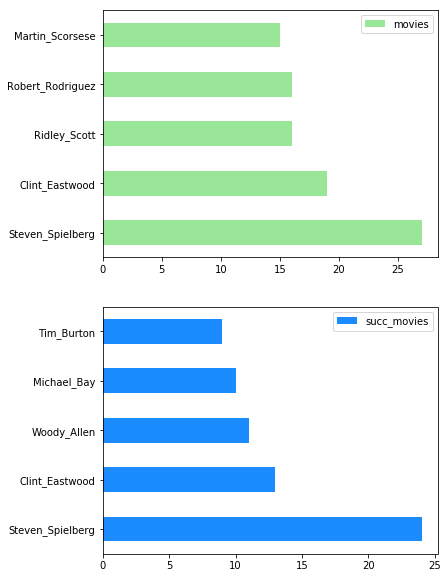

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 10))
directors.nlargest(5).plot.barh(color="#99e699", legend=True, ax=axes[0])
succ_directors.nlargest(5).plot.barh(color="#1a8cff", legend=True, ax=axes[1])
plt.show()

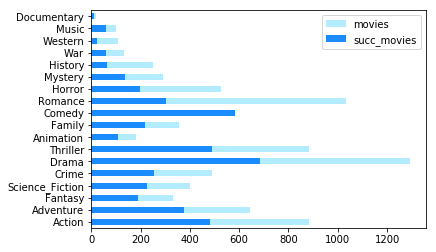

In [7]:
genres.plot.barh(color="#b3ecff", legend=True)
succ_genres.plot.barh(color="#1a8cff", legend=True)
plt.show()

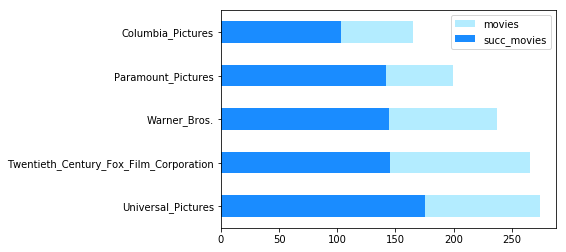

In [8]:
p_companies.nlargest(5).plot.barh(color="#b3ecff", legend=True)
succ_p_companies.nlargest(5).plot.barh(color="#1a8cff", legend=True)
plt.show()

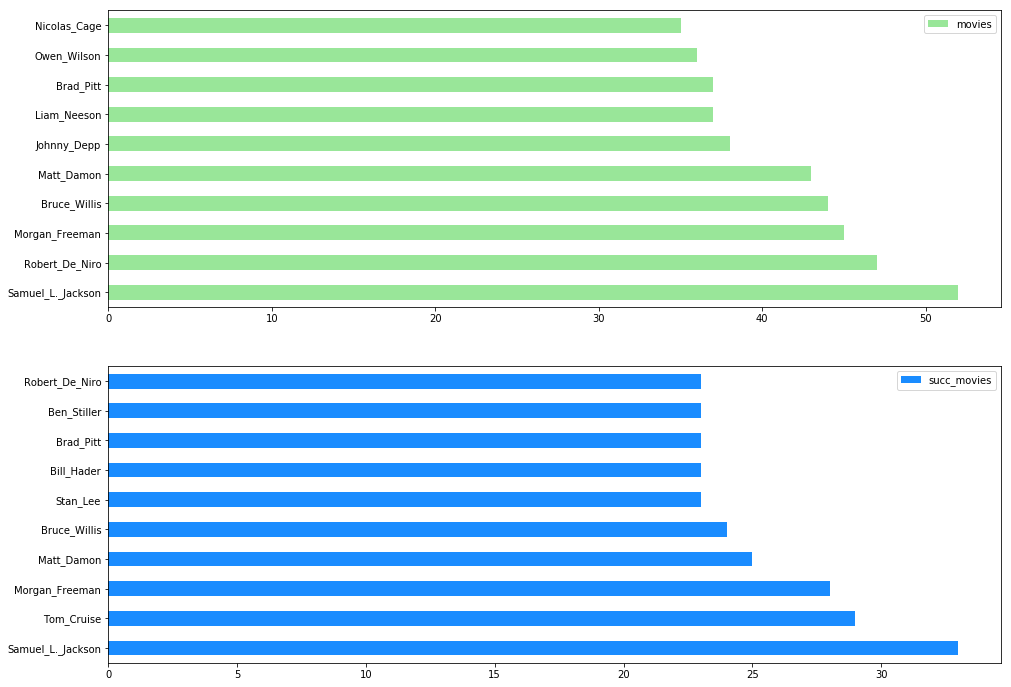

In [9]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))
cast.nlargest(10).plot.barh(color="#99e699", legend=True, ax=axes[0])
succ_cast.nlargest(10).plot.barh(color="#1a8cff", legend=True, ax=axes[1])
plt.show()

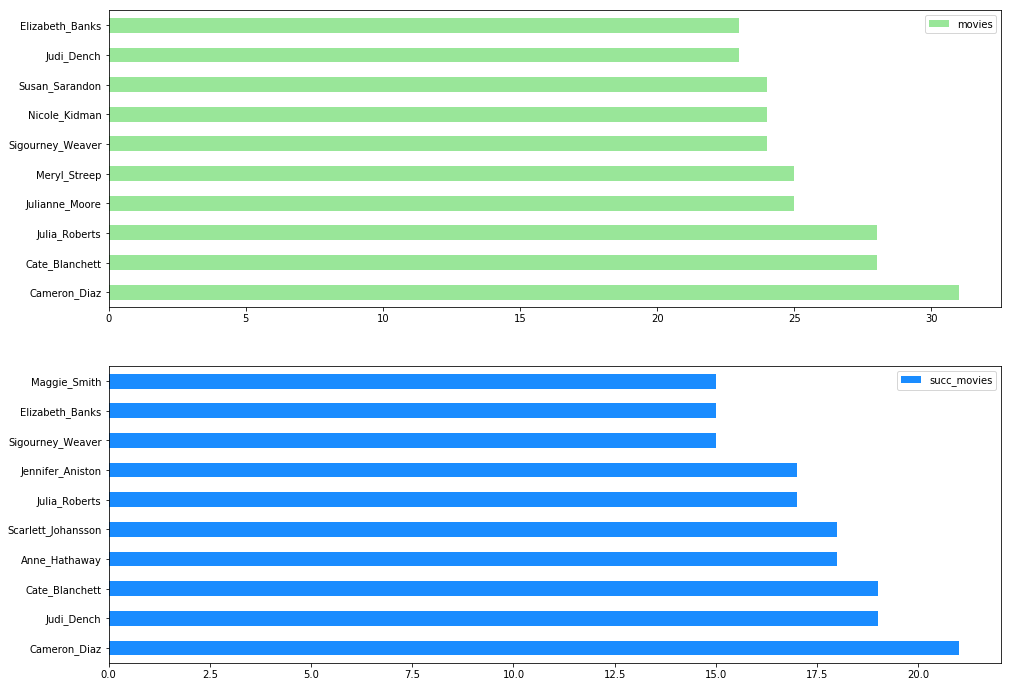

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))
actress.nlargest(10).plot.barh(color="#99e699", legend=True, ax=axes[0])
succ_actress.nlargest(10).plot.barh(color="#1a8cff", legend=True, ax=axes[1])
plt.show()

In [11]:
cast_counts = counts_vectorized(movies, "cast", 28)
dir_counts = counts_vectorized(movies, "directors", 15)
gen_counts = counts_vectorized(movies, "genres", 400)
companies_counts = counts_vectorized(movies, "production_companies", 100)

In [12]:
X=[]
# concatenate vectors count
X = hcat(movies.reset_index(), cast_counts, dir_counts,
         gen_counts, companies_counts)

In [13]:
X = X.drop(columns=["cast", "directors", "genres",
                    "production_companies", "id","actors","actress"])
X = X.set_index("title")

In [14]:
simplify(X, "year", (1, 1998, 2005, 2016), ["vecchio", "contemporaneo", "moderno"])
simplify(X, "runtime", (1, 72, 89, 120, 180, 250), ["XS", "S", "M", "L", "XL"])
simplify(X, "budget", (1, 1e7, 3e7, 6e7, 1e9), ["L", "M", "H", "VH"])
simplify(X, "revenue", (1, 2e7, 6e7, 1e8, 3e9), ["L", "M", "H", "VH"])
simplify(X, "popularity", (-1, 11, 21, 876), ["Low", "Medium", "High"])
simplify(X, "vote_average", (0, 4, 6, 10), ["basso", "normale", "alto"])

y = X.success
X = X.drop(columns="success")
# for one hot encoding
X_h = pd.get_dummies(X)
# label encoder
X_l = encode_features(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_l, y, test_size=0.2, random_state=1)
mc_l = defaultdict(list)

In [16]:
# generate lists of parameters for GridSearch
C_list = [C for C in (0.0001*(10**p) for p in range(1, 8))]
gamma_l = [C for C in [0.1**n for n in range(1, 8)]]
param_grid = {'C': C_list, 'gamma': gamma_l, 'kernel': ['rbf']}
# Make grid search classifier
clf = GridSearchCV(SVC(), param_grid, verbose=0, cv=5).fit(X_train, y_train)
C = clf.best_params_['C']
gamma = clf.best_params_['gamma']
testClassifier(SVC(kernel='rbf', C=C, gamma=gamma), "Optimized RBF SVM",mc_l)

Optimized RBF SVM Scores:

Accuracy: 82.89 %
Precision: 83.24 %
Recall: 88.08 %
Fall out: 16.76 %
False Negative Rate: 11.92 %




In [17]:
testClassifier(LogisticRegression(), "Logistic Regression",mc_l)


Logistic Regression Scores:

Accuracy: 69.80 %
Precision: 71.47 %
Recall: 79.36 %
Fall out: 28.53 %
False Negative Rate: 20.64 %




In [18]:
testClassifier(DecisionTreeClassifier(), "Decision Tree",mc_l)

Decision Tree Scores:

Accuracy: 78.36 %
Precision: 81.90 %
Recall: 80.23 %
Fall out: 18.10 %
False Negative Rate: 19.77 %




In [19]:
clf = RandomForestClassifier()
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)
# Run the grid search
grid_obj = GridSearchCV(
    clf, parameters, scoring=acc_scorer).fit(X_train, y_train)
# Set the clf to the best combination of parameters
testClassifier(grid_obj.best_estimator_, "Random Forest",mc_l)

Random Forest Scores:

Accuracy: 82.89 %
Precision: 83.80 %
Recall: 87.21 %
Fall out: 16.20 %
False Negative Rate: 12.79 %




In [20]:
testClassifier(XGBRegressor(n_estimators=1000, learning_rate=0.05), "Gradient Boosting",mc_l)


Gradient Boosting Scores:

Accuracy: 85.07 %
Precision: 85.32 %
Recall: 89.53 %
Fall out: 14.68 %
False Negative Rate: 10.47 %




In [21]:
from sklearn.decomposition import PCA
pca = PCA(.85) # retain 85% of the variance
X_r = pca.fit_transform(X_l)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_r, y, test_size=0.2, random_state=1)
mc_r = defaultdict(list)

### SVM
testClassifier(SVC(kernel='rbf', C=C, gamma=gamma), "Optimized RBF SVM",mc_r)

### Random Forest
clf = RandomForestClassifier()
acc_scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer).fit(X_train, y_train)
testClassifier(grid_obj.best_estimator_, "Random Forest",mc_r)

### XGBR
testClassifier(XGBRegressor(n_estimators=1000, learning_rate=0.05), "Gradient Boosting",mc_r)

comparison_r = pd.DataFrame(mc_r, columns=['classifier','accuracy','fallout'])

Optimized RBF SVM Scores:

Accuracy: 83.89 %
Precision: 85.63 %
Recall: 86.63 %
Fall out: 14.37 %
False Negative Rate: 13.37 %


Random Forest Scores:

Accuracy: 82.89 %
Precision: 82.70 %
Recall: 88.95 %
Fall out: 17.30 %
False Negative Rate: 11.05 %


Gradient Boosting Scores:

Accuracy: 82.05 %
Precision: 83.01 %
Recall: 86.63 %
Fall out: 16.99 %
False Negative Rate: 13.37 %




In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_h, y, test_size=0.2, random_state=1)
mc_h = defaultdict(list)

### SVM
testClassifier(SVC(kernel='rbf', C=C, gamma=gamma), "Optimized RBF SVM",mc_h)
### Random Forest
clf = RandomForestClassifier()
acc_scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer).fit(X_train, y_train)
testClassifier(grid_obj.best_estimator_, "Random Forest",mc_h)
### XGBR
testClassifier(XGBRegressor(n_estimators=1000, learning_rate=0.05), "Gradient Boosting",mc_h)

comparison_h = pd.DataFrame(mc_h, columns=['classifier','accuracy','fallout'])

Optimized RBF SVM Scores:

Accuracy: 84.06 %
Precision: 84.11 %
Recall: 89.24 %
Fall out: 15.89 %
False Negative Rate: 10.76 %


Random Forest Scores:

Accuracy: 83.72 %
Precision: 81.27 %
Recall: 93.31 %
Fall out: 18.73 %
False Negative Rate: 6.69 %


Gradient Boosting Scores:

Accuracy: 85.74 %
Precision: 86.27 %
Recall: 89.53 %
Fall out: 13.73 %
False Negative Rate: 10.47 %




In [24]:
comparison_h = comparison_h.set_index("classifier")
comparison_r = comparison_r.set_index("classifier")
comparison_l = comparison_l.set_index("classifier")
comparison = comparison_h.join(comparison_r,rsuffix = "_pca",lsuffix="_1hot")
comparison = comparison.join(comparison_l,rsuffix = "_label")
comparison.plot.bar()
plt.show()

NameError: name 'comparison_l' is not defined